u_x^2 ------>   4.9124374071(actual value=4.91545032899), sigma ------>0.0126049011804
u_x ------>   0.611612479817(actual value=0.610228556063), sigma ------>0.00133138348016
u_xx ------>   -0.987704897991(actual value=-1.0), sigma ------>0.00338614272416
u_xxx ------>   0.000130151550915(actual value=0.0), sigma ------>0.000996200602138
u_xxxx ------>   -0.999266632948(actual value=-1.0), sigma ------>0.00275071940678
u_x^3 ------>   0.63439132357(actual value=0.671080027715), sigma ------>0.0190627595982


/Users/Bradley/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:474: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(-5, 5)

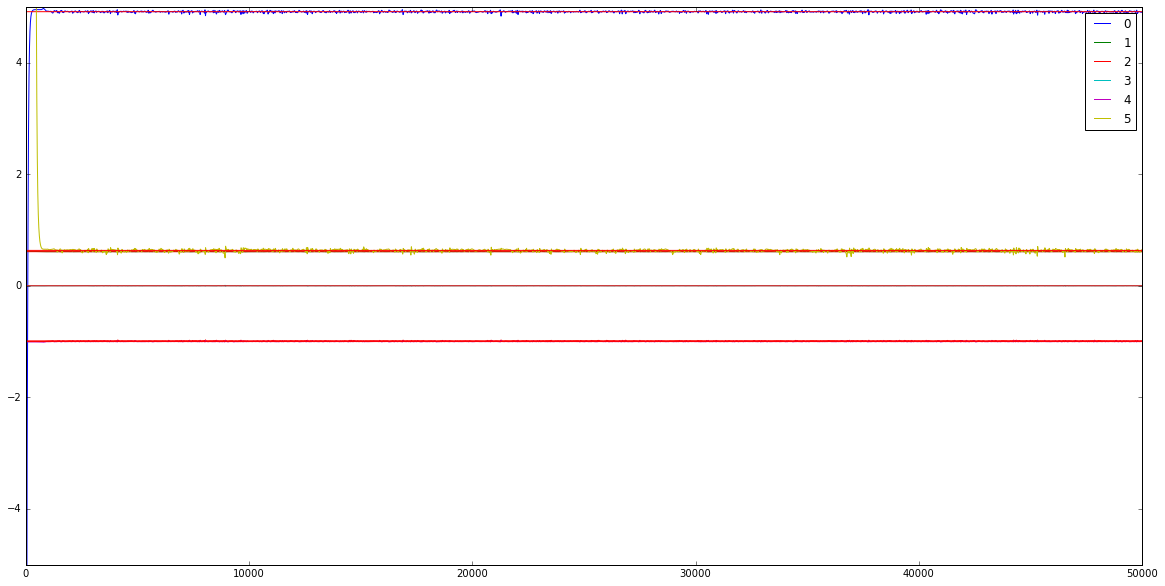

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random as rand
%matplotlib inline
import time
### This is code to take two surface snapshots at similar times,
### and estimate the coefficients of the PDE that governs the surface
### It is necessary to include all potential terms in the equation of motion, or results may be unreliable
### (Note: It is OK to consider more terms than the actual PDE.  Theoretical upper limit on retained terms is N for 1D, N^2 for 2D)
### Begin by assigning each term an index i, and defining the Functional function below to include these
### Default input is an array FF such that FF[i] is the Fourier transform of a surface at time i*dt
### Need to specify N, L, dt for algorithm to operate
###
### Basic strategy is to find a vector x such that vdot = \hat{B} . x  is satisfied where
### vdot = discrete time derivative, found at time dt*i by using the udot(FF,i) function.  Has a length of N
### x    = vector of coefficient values (i.e. the thing we're after).  Has length of funcnum
### \hat{B}= A matrix of all considered functions evaluated at each point in space at time t=dt*i. 
### e.g. B_{ij} = the ith function defined in Functional evaluated for the jth fourier mode at time t=dt*i
### This matrix is computed by the BIGMAT function

N=201        #Number of discretized points
L=100        #Sample Length
dt=.05       #length of one discretized time step
dx=N/float(L)  #length of one discretized space step
funcnum=6    #Number of functions defined in Functional(u,i)
#### DEFINE FUNCTIONS HERE
def gv_definition():
    n=int(N/2)
    gv=[]
    for i in range(-n,n+1):
        gv.append(1.0j*i*2*np.pi/L) ###vector gv is used to perform derivatives in Fourier space
    return np.array(np.roll(gv,-n))
gv=gv_definition()
def Functional(v,i):
    ## Define the various functions to be considered here.  i should range from 0 to funcnum-1 with no gaps
    u=np.fft.ifft(v)
    realgv=gv
    if i==0:
        vnew=realgv*np.fft.fft(np.real(u)**2)
        return vnew
    if i==1:
        vnew=realgv*v
        return vnew
    if i==2:
        vnew=realgv**2*v
        return vnew
    if i==3:
        vnew=realgv**3*v
        return vnew
    if i==4:
        vnew=realgv**4*v
        return vnew
    if i==5:
        vnew=realgv*np.fft.fft(np.real(u)**3)
        return vnew
def vdot(Fourlist,i):
    #Computes the discrete time derivative using forward differencing at t=dt*i
    return (Fourlist[i+1]-Fourlist[i])/dt

def BIGMAT(Fourlist,i,funcnum):
    v=Fourlist[i]
    bmat=np.zeros([len(v),funcnum],dtype=complex)
    for j in range(funcnum):
        bmat[:,j]=Functional(v,j)
    return bmat
Fourlist=np.load("Example Fourlist.npy")  #List of Fourier transforms of the surface
real_coeffs=np.load("Example coeffs.npy") #List of true coefficients used to make Example Fourlist
coeff_list=[]
for t0 in range(len(Fourlist)-1):
    B=BIGMAT(Fourlist,t0,funcnum) #Define B at this time
    v_dot=vdot(Fourlist,t0)       #Calculate u dot at this time
    X=(np.linalg.lstsq(B,v_dot))[0] #least squares fit for x
    coeff_list.append(X)            #Store this estimate of X
coeff_array=np.array(coeff_list)
###################################
## AVERAGE AND PLOT COEF VALUES HERE
istart=1000 #minimum value of i to be considered

average_values=np.real(np.mean(coeff_array[istart:],0)) #Finds average estimated coefficient values
average_deviation=np.std(np.real(coeff_array[istart:]),0) #Standard deviation of same

print("u_x^2 ------>   "+str(average_values[0])+"(actual value="+str(real_coeffs[0])+")"+", sigma ------>"+str(average_deviation[0]))
print("u_x ------>   "+str(average_values[1])+"(actual value="+str(real_coeffs[1])+")"+", sigma ------>"+str(average_deviation[1]))
print("u_xx ------>   "+str(average_values[2])+"(actual value="+str(real_coeffs[2])+")"+", sigma ------>"+str(average_deviation[2]))
print("u_xxx ------>   "+str(average_values[3])+"(actual value="+str(real_coeffs[3])+")"+", sigma ------>"+str(average_deviation[3]))
print("u_xxxx ------>   "+str(average_values[4])+"(actual value="+str(real_coeffs[4])+")"+", sigma ------>"+str(average_deviation[4]))
print("u_x^3 ------>   "+str(average_values[5])+"(actual value="+str(real_coeffs[5])+")"+", sigma ------>"+str(average_deviation[5]))


plt.figure(figsize=[20,10])
for j in range(len(coeff_array[1])):
    plt.plot(coeff_array[:,j],label=str(j))
    plt.plot(np.arange(len(coeff_array)),[np.real(np.mean(coeff_array[istart:],0))[j]]*len(coeff_array),'r-')
plt.legend()


plt.ylim([-5,5])